# Machine Leaning Project

## Car Sale Adverts dataset


#### Importing Important Libraries

In [ ]:
!pip install phik
!pip install shap
!pip install -q category_encoders
!pip install --upgrade scikit-learn category_encoders -q --user

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [ ]:
import shap
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt



from functools import partial
from sklearn.decomposition import PCA
from category_encoders import TargetEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.inspection import PartialDependenceDisplay
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score, GridSearchCV, train_test_split
from sklearn.ensemble import RandomForestRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import explained_variance_score,mean_absolute_error,r2_score, mean_squared_error



%matplotlib inline
rmse = partial(mean_squared_error, squared=False)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings(action="ignore", message="^internal gelsd")


## 1. Data Processing for Machine Learning

### 1.1. Meaning and Type of Features

#### load the dataset

In [ ]:
# Uploading the Car Advert data file from your local computer
at = pd.read_csv('C:/Users/22501623/OneDrive - MMU/DS and ML/DS_ML_Project/adverts (1).csv')
#df.head()

#### sample observations

In [ ]:
# displaying 10 sample obervations
df.sample(10)

,public_reference,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
42613,202006180259978,8.0,70,Blue,Volvo,V60,USED,2020.0,34000,Estate,False,Petrol
353179,202010165073268,39000.0,65,White,BMW,i3,USED,2015.0,16295,Hatchback,False,Petrol Hybrid
325651,202010054638569,101355.0,59,Black,Audi,A3,USED,2010.0,4490,Hatchback,False,Petrol
307397,202010195162144,84887.0,10,White,Audi,Q5,USED,2010.0,9990,SUV,False,Diesel
204804,202009213993434,43391.0,16,Black,BMW,5 Series,USED,2016.0,15500,Saloon,False,Diesel
247547,202009234110393,67000.0,62,White,BMW,1 Series,USED,2012.0,7425,Hatchback,False,Petrol
314270,202010285539862,12936.0,18,Silver,Toyota,Auris,USED,2018.0,13995,Hatchback,False,Petrol Hybrid
274433,202011015669296,124000.0,07,Silver,Volkswagen,Golf,USED,2007.0,2250,Hatchback,False,Petrol
3430,202007040839853,84000.0,67,Silver,Toyota,Prius,USED,2017.0,12450,Hatchback,False,Petrol Hybrid
180335,202010074711298,27000.0,67,White,Hyundai,i30,USED,2018.0,11369,Hatchback,False,Petrol


#### Correct parsing of data

In [ ]:
# Displaying rows and columns of dataset
df.shape

(402005, 12)

There are 402005 rows and 12 columns in the dataset.

In [ ]:
# to show the number of columns/varibles in the dataset
df.columns

Index(['public_reference', 'mileage', 'reg_code', 'standard_colour',
       'standard_make', 'standard_model', 'vehicle_condition',
       'year_of_registration', 'price', 'body_type', 'crossover_car_and_van',
       'fuel_type'],
      dtype='object')

#### Analyse data distributions (e.g., range, centrality, dispersion, shape)

In [ ]:
# A quick description of the dataframe with .info()
# Noticed missing values in some features.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 402005 entries, 0 to 402004
Data columns (total 12 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   public_reference       402005 non-null  int64  
 1   mileage                401878 non-null  float64
 2   reg_code               370148 non-null  object 
 3   standard_colour        396627 non-null  object 
 4   standard_make          402005 non-null  object 
 5   standard_model         402005 non-null  object 
 6   vehicle_condition      402005 non-null  object 
 7   year_of_registration   368694 non-null  float64
 8   price                  402005 non-null  int64  
 9   body_type              401168 non-null  object 
 10  crossover_car_and_van  402005 non-null  bool   
 11  fuel_type              401404 non-null  object 
dtypes: bool(1), float64(2), int64(2), object(7)
memory usage: 34.1+ MB


In [ ]:
# set 'public_reference' as index columns
df = df.set_index('public_reference')

In [ ]:
#Let's look at the numeric values with .describe()
df.describe()

,mileage,year_of_registration,price
count,401878.000000,368694.000000,4.020050e+05
mean,37743.595656,2015.006206,1.734197e+04
std,34831.724018,7.962667,4.643746e+04
min,0.000000,999.000000,1.200000e+02
25%,10481.000000,2013.000000,7.495000e+03
50%,28629.500000,2016.000000,1.260000e+04
75%,56875.750000,2018.000000,2.000000e+04
max,999999.000000,2020.000000,9.999999e+06


From above we can see the statistics of numerical columns, there are some missing values in mileage and year_of_registration column, and also there is zero minimum value in mileage cloumn and 999 in year_of_registration which is not possible, it is a nosie we need to replace these values.

#### Identifying Quantitative and Qualitative features

There are 2 quantitive (price & mileage) columns other 9 are qualitative columns in dataset we have 2 float columns, one integer and one bool column and 7 object/categorical columns

In [ ]:
# Creating list of all categorical features
cat_feat_lst = df.select_dtypes(include = ['object']).columns
cat_feat_lst.tolist()

['reg_code',
 'standard_colour',
 'standard_make',
 'standard_model',
 'vehicle_condition',
 'body_type',
 'fuel_type']

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='mileage', ylabel='Density'>

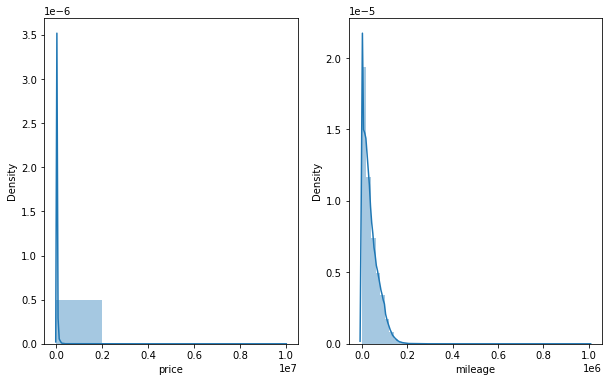

In [ ]:
# Distribution plot of mileage and price features
plt.figure(figsize=[10,6])
plt.subplot(121)
sns.distplot(df['price'], bins=5)
plt.subplot(122)
sns.distplot(df['mileage'])

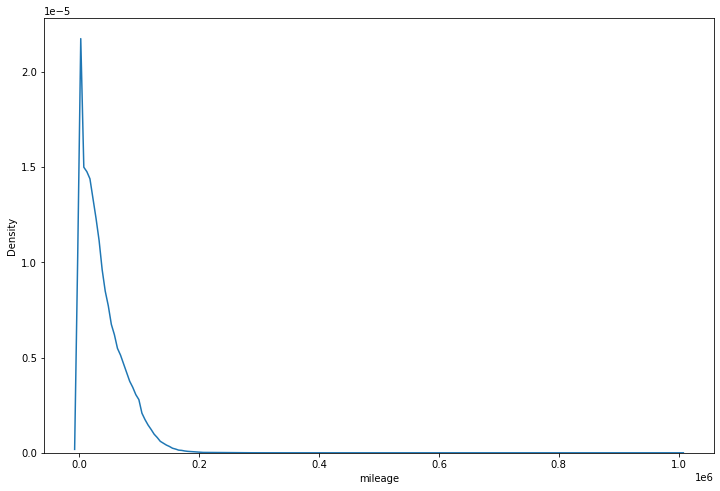

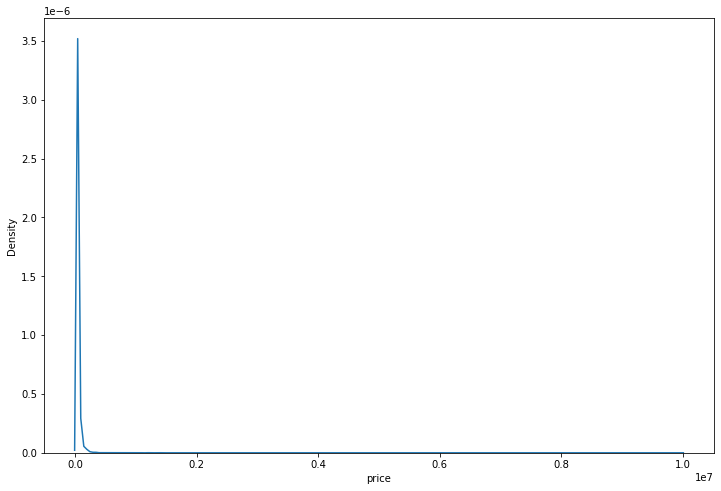

In [ ]:
# Density plots of numerical features
num_feat_lst = ['mileage','price']
for feature in num_feat_lst:
    plt.figure(figsize=(12,8))
    sns.kdeplot(data=df, x=feature, palette="crest")
    #plt.xscale('log')
    plt.show()

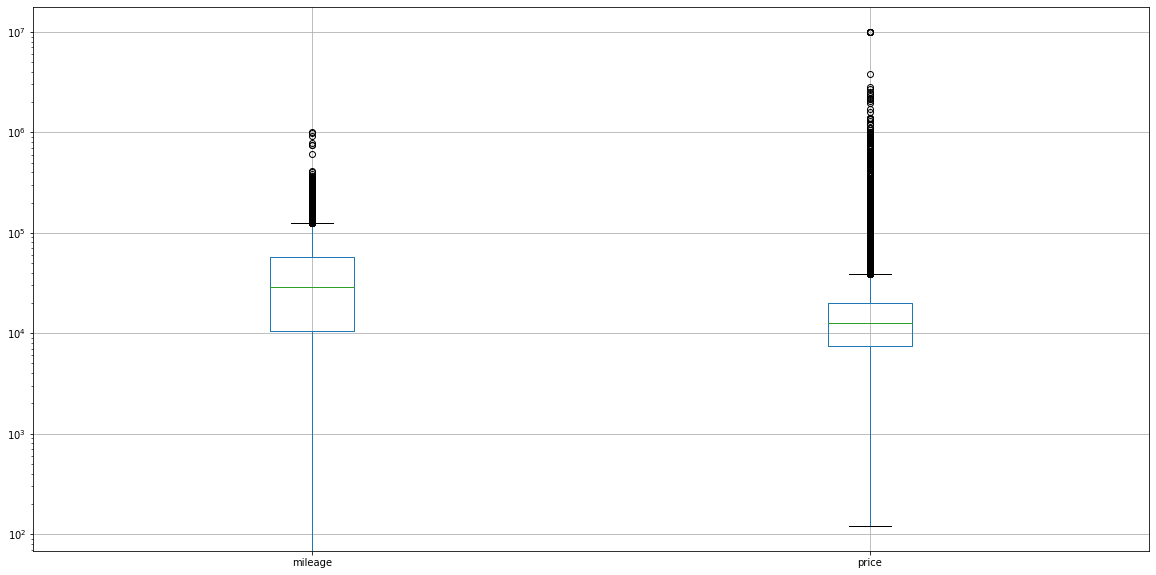

In [ ]:
# Boxplots of numerical features on logrithimic scale
num_feat= ['mileage', 'price']
plt.figure(figsize=(20,10))
df[num_feat].boxplot()
plt.yscale("log")

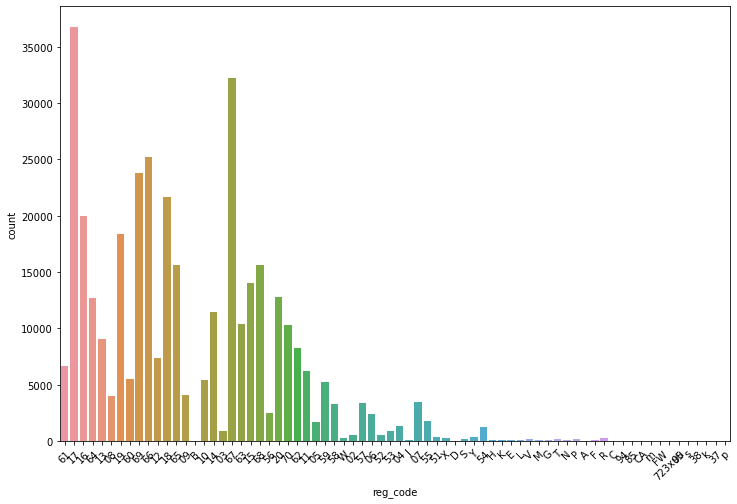

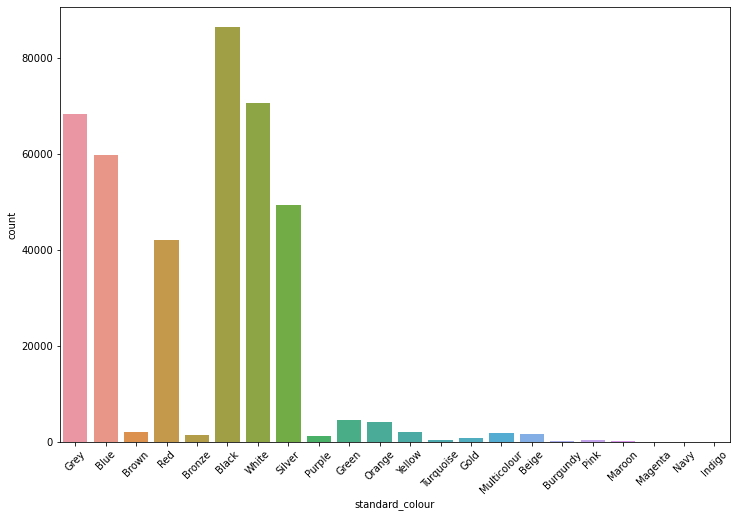

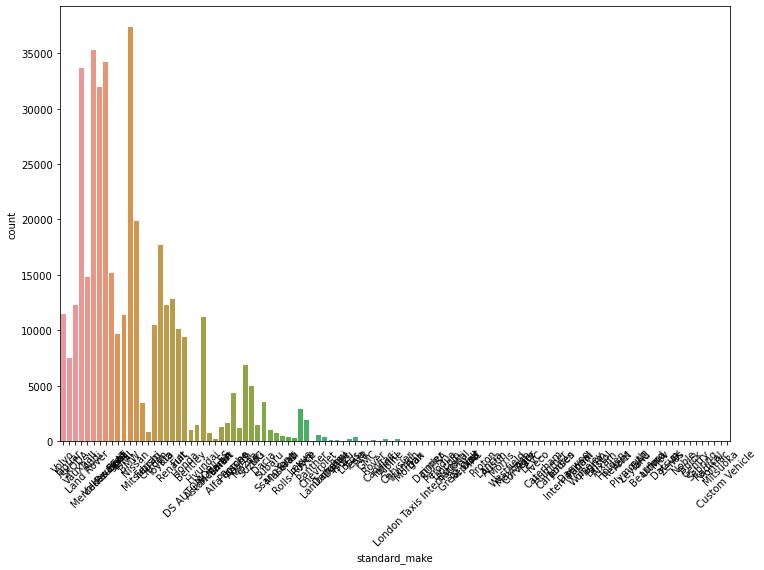

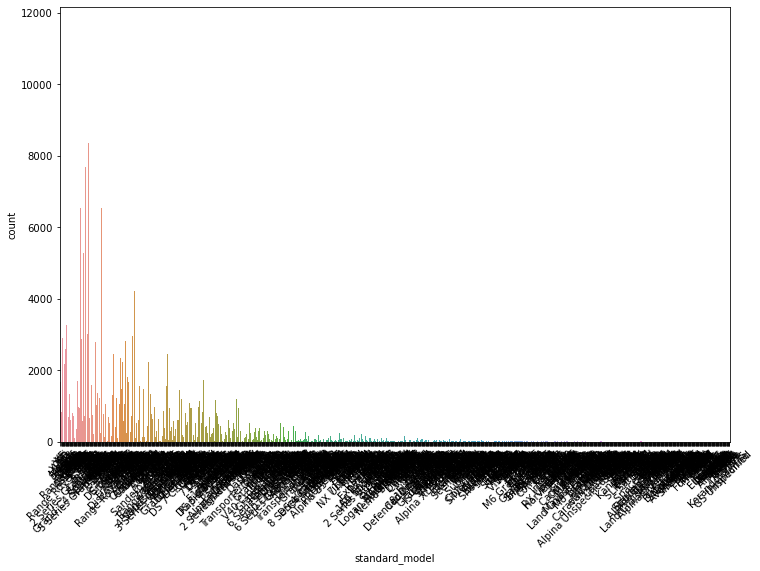

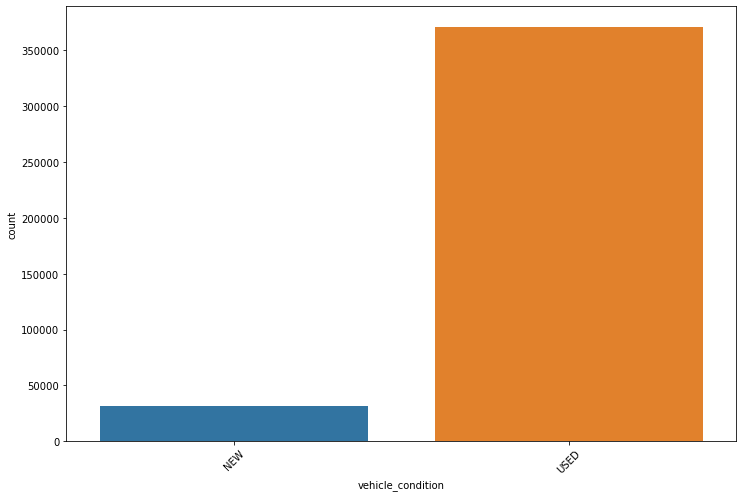

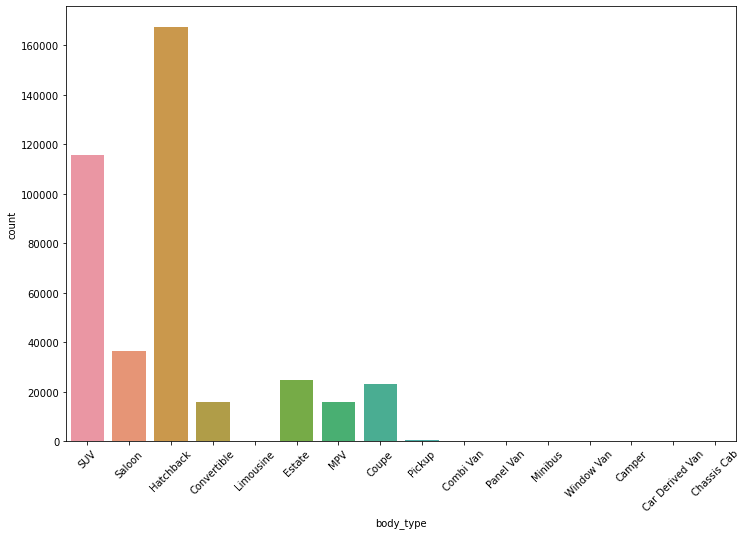

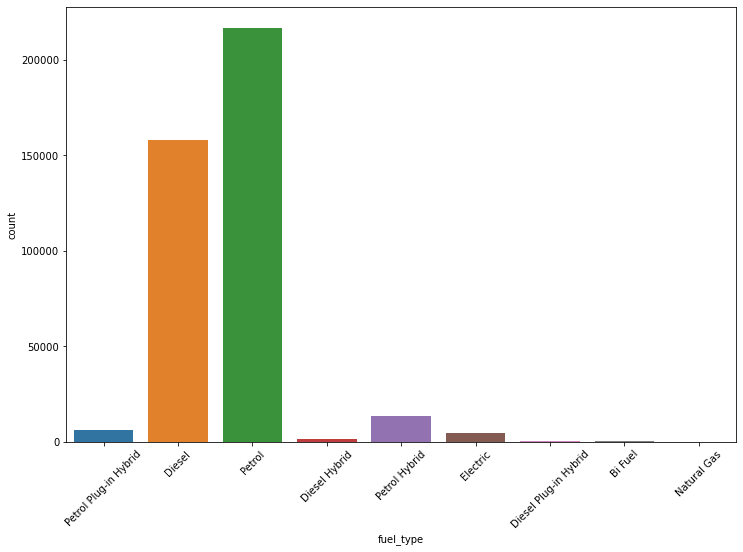

In [ ]:
# Count plots of categorical features
for feature in cat_feat_lst:
    plt.figure(figsize=(12,8))
    sns.countplot(x=df[feature])
    #plt.xscale('log')
    plt.xticks(rotation=45)
    plt.show()

####  Dealing with Missing Values

From above we can see the missing values in mileage, reg_code, standard_colour and year_of_registration, body_type and fuel_type columns.

In [ ]:
# finding the missing values of year_of_registration by reg_code
reg_cod_lst = df['reg_code'].unique().tolist()
sum_t = 0
for k in reg_cod_lst:
    null_sum = df[df['reg_code']== k]['year_of_registration'].isna().sum()
    sum_t += null_sum
    #print(f"Missing value in reg_code {k} are {null_sum} can be replaced by {v}")
print(f'Total mising values in year_of_registration related to reg_code are {sum_t}')

Total mising values in year_of_registration related to reg_code are 1741


In [ ]:
# Finding missing values in year_of_registration grouped with vechile_condition by NEW CARs
df.groupby('vehicle_condition')['year_of_registration'].get_group('NEW').isna().sum()

31249

Here, we can see the moslty missing values in year of registration column are related to NEW Cars

In [ ]:
# Finding missing values in year_of_registration grouped with vechile_condition by USED CARs
df.groupby('vehicle_condition')['year_of_registration'].get_group('USED').isna().sum()

2062

There are 8627 duplicate values in dataset

In [ ]:
# droping Duplicate values
df = df.drop_duplicates()

### 1.3. Identification/Commenting on Outliers and Noise (1-2)

#### Outliers

Here, we can see that the minimum price is gerater then 100

here from above prices there is top 20 high price range for the column, we can see the high price is 9,999,999 when compared to other there is big difference. So we need to remove this outlier.

Here we can see the of the values are related to 0 mileage, which is of new cars.

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


<AxesSubplot:xlabel='mileage', ylabel='Density'>

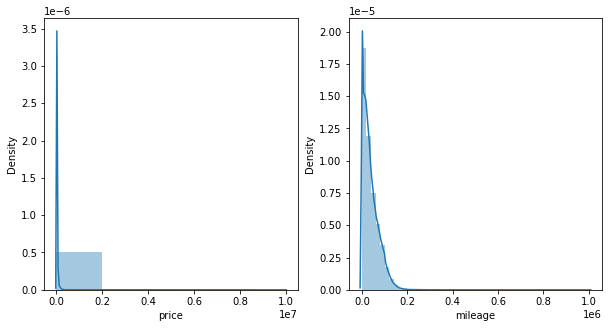

In [ ]:
# Distribution plot of mileage and price features
plt.figure(figsize=[10,5])
plt.subplot(121)
sns.distplot(df['price'], bins=5)
plt.subplot(122)
sns.distplot(df['mileage'])

Here we can see there is big difference b/w minimum value and 25th percentile and b/w maximum value and 75th perentile, so we need to remove 10% from both ends.

### 1.3. Data Processing for Data Exploration and Visualisation (1-2)


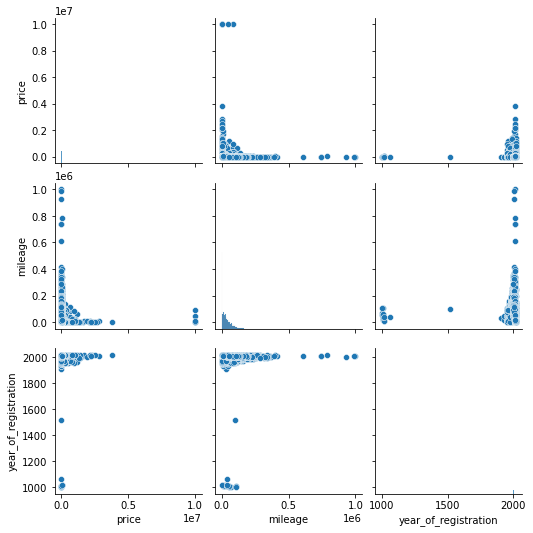

In [ ]:
# Correlation matrix plot
ax = sns.pairplot(df[['price','mileage','vehicle_condition','year_of_registration']])
#ax.fig.suptitle('Correlation matrix plot', y=1.02)

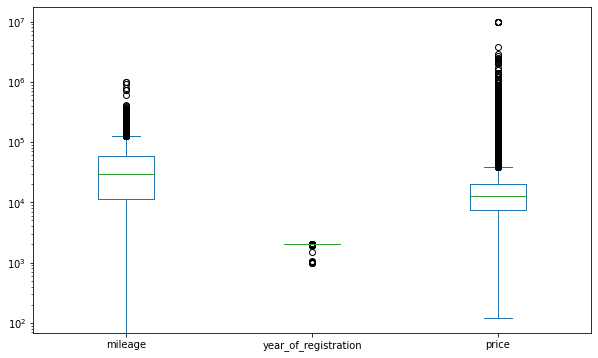

In [ ]:
# Boxplot of numerical variables
df.plot(kind='box',figsize=(10,6))
plt.yscale('log')

## 2. Data Processing for Machine Learning

In [ ]:
# Removing noise in reg_code feature
df['reg_code'] = df['reg_code'].str.strip()

In [ ]:
# Removing noise in reg_code feature
df['reg_code'] = df['reg_code'].str.upper()

In [ ]:
# creating a dictionary to assigining the year_of_rigistarion to related reg_code and the reference for
# assignment of these years value is given below
# https://en.wikipedia.org/wiki/Vehicle_registration_plates_of_the_United_Kingdom
year_reg_dict = {'61': 2011, '17':2017, '16':2016, '64':2014, '13':2013, '08':2008, '19':2019, '60':2010, '69':2019, '66':2016,
                 '12':2012, '18':2018, '65':2015, '09':2009, 'B':1984, '10':2010, '14':2014, '03':2003, '67':2017, '63':2013,
                 '15':2015,'68':2018, '56':2006, '20':2020, '70':2020, '62':2012, '11':2011, '05':2005, '59':2009, '58':2008,
                 'W':2000, '02':2002, '57':2007, '06':2006, '52':2002, '53':2003, '04':2004, 'J':1991, '07':2007, '55':2005,
                 '51':2001, 'X':2000, 'D':1986, 'S':1998, 'Y':2001, '54':2004, 'H':1990, 'K':1992, 'E':1987, 'L':1993, 'V':1999,
                 'M':1994, 'G':1989, 'T':1999, 'N':1995, 'P':1996, 'A':1983, 'F':1988, 'R':1997, 'C':1985, '94':np.nan, '85':np.nan,
                 'CA':np.nan, 'FW':1974, '723XUU':1964, '95':np.nan, '38':np.nan, '37':np.nan}

In [ ]:
# Replacing the missing values by actual values using the wikipeida reference
for k,v in year_reg_dict.items():
    df_1 = df[(df['reg_code']== k) & (df['year_of_registration'].isna())]['year_of_registration'].replace(np.nan, v)
    df.update(df_1)

In [ ]:
# finding median value of registration related to used vehicle condition
used_median = df.groupby('vehicle_condition')['year_of_registration'].get_group('USED').median()

In [ ]:
# Replacing missing values of registration related to used vehicle condition by median value
df_used = df[(df['vehicle_condition']== 'USED') & (df['year_of_registration'].isna())]['year_of_registration'].fillna(used_median)
df.update(df_used)

In [ ]:
# finding values between 1900 to 2020
(df['year_of_registration'].between(1900,2020)).sum() / df.shape[0]

0.9377087686652533

In [ ]:
# set range of registration year between 1900 and 2020

df['year_of_registration'] = np.where(df['vehicle_condition'] == "NEW", 2021, df['year_of_registration'])
df['reg_code'] = np.where(df['year_of_registration'] == 2021, 21, df['reg_code'])

In [ ]:
# converting datatype of registration year into intiger
df['year_of_registration'] = df['year_of_registration'].astype('int64')

**Replacing missing values of mileage feature by median values based on groups standard_make and standard_model.**

In [ ]:
# finding mileage median values related to car brands and car models
def find_mileage_median(x):
    make = x.name[0]
    if x.count() > 0:
        return x.median() # It Returns median if the median exists for the model.
    elif df.groupby(['standard_make'])['mileage'].count()[make] > 0:
        make_median = df.groupby(['standard_make'])['mileage'].apply(lambda x: x.median())[make]
        return make_median # It Return median if particular car make,
    else:
        return df['mileage'].median() # It returns the median of 'mileage' feature.

m_median = df.groupby(['standard_make','standard_model'])['mileage'].apply(find_mileage_median).reset_index()
m_median.rename(columns={'mileage': 'mileage_med'}, inplace=True)
m_median.head()

,standard_make,standard_model,mileage_med
0,AC,Cobra,700.0
1,AK,Cobra,3000.0
2,Abarth,124 Spider,11000.0
3,Abarth,500,49000.0
4,Abarth,500C,36527.0


In [ ]:
# applying median values to null values in mileage columns
def median_value(x):
    if pd.isnull(x['mileage']):
        return m_median[(m_median['standard_make'] == x['standard_make']) & (m_median['standard_model'] == x['standard_model'])]['mileage_med'].values[0]
    else:
        return x['mileage']

df['mileage'] = df.apply(median_value, axis=1)

**Replacing missing values of Fuel_type feature by mode value based on groups standard_make and standard_model.**

In [ ]:
# finding fuel_type mode values related to car brands and car models
def find_fuelType_mode(x):
    make = x.name[0]
    if x.count() > 0:
        return x.mode() # It Returns mode if the mode exists for the model.
    elif df.groupby(['standard_make'])['fuel_type'].count()[make] > 0:
        make_mode = df.groupby(['standard_make'])['fuel_type'].apply(lambda x: x.mode())[make]
        return make_mode # It Return mode if particular car make,
    else:
        return df['fuel_type'].mode() # It returns the mode of 'fuel_type' feature.

ft_mode = df.groupby(['standard_make','standard_model'])['fuel_type'].apply(find_fuelType_mode).reset_index().drop('level_2', axis=1)
ft_mode.rename(columns={'fuel_type': 'fuel_type_mod'}, inplace=True)
ft_mode.head()

,standard_make,standard_model,fuel_type_mod
0,AC,Cobra,Petrol
1,AK,Cobra,Petrol
2,Abarth,124 Spider,Petrol
3,Abarth,500,Petrol
4,Abarth,500C,Petrol


In [ ]:
# applying mode values to null values in fuel_type column
def mode_value(x):
    if pd.isnull(x['fuel_type']):
        return ft_mode[(ft_mode['standard_make'] == x['standard_make']) & (ft_mode['standard_model'] == x['standard_model'])]['fuel_type_mod'].values[0]
    else:
        return x['fuel_type']

df['fuel_type'] = df.apply(mode_value, axis=1)
df.head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
public_reference,,,,,,,,,,,
202006039777689,0.0,21,Grey,Volvo,XC90,NEW,2021,73970,SUV,False,Petrol Plug-in Hybrid
202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011,7000,Saloon,False,Diesel
202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017,14000,SUV,False,Petrol
202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016,7995,Hatchback,False,Diesel
202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015,26995,SUV,False,Diesel


**Replacing missing values of Body_Type feature by mode values based on groups standard_make and standard_model.**

In [ ]:
# finding body_type mode values related to car brands and car models
def find_bodyType_mode(x):
    make = x.name[0]
    if x.count() > 0:
        return x.mode() # It Returns mode if the mode exists for the model.
    elif df.groupby(['standard_make'])['body_type'].count()[make] > 0:
        make_mode = df.groupby(['standard_make'])['body_type'].apply(lambda x: x.mode())[make]
        return make_mode # It Return mode if particular car make,
    else:
        return df['body_type'].mode() # It returns the mode of 'body_type' feature.

bt_mode = df.groupby(['standard_make','standard_model'])['body_type'].apply(find_bodyType_mode).reset_index().drop('level_2', axis=1)
bt_mode.rename(columns={'body_type': 'body_type_mod'}, inplace=True)
bt_mode.head()

,standard_make,standard_model,body_type_mod
0,AC,Cobra,Convertible
1,AK,Cobra,Convertible
2,Abarth,124 Spider,Convertible
3,Abarth,500,Hatchback
4,Abarth,500C,Convertible


In [ ]:
# applying mode values to null values body_type column
def mode_value(x):
    if pd.isnull(x['body_type']):
        return bt_mode[(bt_mode['standard_make'] == x['standard_make']) & (bt_mode['standard_model'] == x['standard_model'])]['body_type_mod'].values[0]
    else:
        return x['body_type']

df['body_type'] = df.apply(mode_value, axis=1)
df.head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
public_reference,,,,,,,,,,,
202006039777689,0.0,21,Grey,Volvo,XC90,NEW,2021,73970,SUV,False,Petrol Plug-in Hybrid
202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011,7000,Saloon,False,Diesel
202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017,14000,SUV,False,Petrol
202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016,7995,Hatchback,False,Diesel
202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015,26995,SUV,False,Diesel


**Replacing missing values of Standard_Colour feature by median values based on groups standard_make and standard_model**

In [ ]:
# finding Standard_colour mode values related to car brands and car models
def find_stdColour_mode(x):
    make = x.name[0]
    if x.count() > 0:
        return x.mode() # It Returns mode if the mode exists for the model.
    elif df.groupby(['standard_make'])['standard_colour'].count()[make] > 0:
        make_mode = df.groupby(['standard_make'])['standard_colour'].apply(lambda x: x.mode())[make]
        return make_mode # It Return mode if particular car make,
    else:
        return df['standard_colour'].mode() # It returns the mode of 'standard_colour' feature.

stdC_mode = df.groupby(['standard_make','standard_model'])['standard_colour'].apply(find_stdColour_mode).reset_index().drop('level_2', axis=1)
stdC_mode.rename(columns={'standard_colour': 'standard_colour_mod'}, inplace=True)
stdC_mode.head()

,standard_make,standard_model,standard_colour_mod
0,AC,Cobra,White
1,AK,Cobra,Grey
2,Abarth,124 Spider,Red
3,Abarth,500,White
4,Abarth,500C,Grey


In [ ]:
# applying mode values to null values in standard colour column
def mode_value(x):
    if pd.isnull(x['standard_colour']):
        return stdC_mode[(stdC_mode['standard_make'] == x['standard_make']) & (stdC_mode['standard_model'] == x['standard_model'])]['standard_colour_mod'].values[0]
    else:
        return x['standard_colour']

df['standard_colour'] = df.apply(mode_value, axis=1)
df.head()

,mileage,reg_code,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type
public_reference,,,,,,,,,,,
202006039777689,0.0,21,Grey,Volvo,XC90,NEW,2021,73970,SUV,False,Petrol Plug-in Hybrid
202007020778260,108230.0,61,Blue,Jaguar,XF,USED,2011,7000,Saloon,False,Diesel
202007020778474,7800.0,17,Grey,SKODA,Yeti,USED,2017,14000,SUV,False,Petrol
202007080986776,45000.0,16,Brown,Vauxhall,Mokka,USED,2016,7995,Hatchback,False,Diesel
202007161321269,64000.0,64,Grey,Land Rover,Range Rover Sport,USED,2015,26995,SUV,False,Diesel


In [ ]:
# droping reg_code vehicle_condition columns
df = df.drop(['reg_code'], axis =1)

**capitalization issues, extra spaces on strings**

In [ ]:
# capitalization issues, extra spaces on strings
df['standard_model'] = df['standard_model'].str.upper()
# Removing capatlize issue in standard_make
df['standard_make'] = df['standard_make'].str.upper()
# Removing capatlize issue in standard_colour
df['standard_colour'] = df['standard_colour'].str.upper()
# Removing capatlize issue in vehicle_condition
#df['vehicle_condition'] = df['vehicle_condition'].str.upper()
# Removing capatlize issue in fuel_type
df['fuel_type'] = df['fuel_type'].str.upper()
# Removing capatlize issue in body_type
df['body_type'] = df['body_type'].str.upper()

In [ ]:
# null values in each feature
df.isna().sum().sort_values(ascending=False)

mileage                  0
standard_colour          0
standard_make            0
standard_model           0
vehicle_condition        0
year_of_registration     0
price                    0
body_type                0
crossover_car_and_van    0
fuel_type                0
dtype: int64

### Dealing with Outliers and Noise

here from above prices there is top 20 high price range for the column, we can see the high price is 9,999,999 when compared to other there is big difference. So we need to remove this outlier.

In [ ]:
df_new = df[df['vehicle_condition']=='NEW']
df_used = df[df['vehicle_condition']=='USED']

In [ ]:
# finding the 10% price values from both max and min ends
sort_price = sorted(df_new['price'])
q1, q2 = np.percentile(sort_price,[10,90])
print(q1,q2)

15700.0 63374.20000000003


In [ ]:
# finding the 10% price values from both max and min ends
sort_price = sorted(df_used['price'])
q1, q2 = np.percentile(sort_price,[10,90])
print(q1,q2)

3800.0 28500.0


In [ ]:
# finding the 10% price values from both max and min ends
sort_mileage = sorted(df_used['mileage'])
q1, q2 = np.percentile(sort_mileage,[10,90])
print(q1,q2)

5200.0 90000.0


In [ ]:
# setting the range of price between 3996.0 and 31500
df_new = df_new[(df_new.price <=63375) & (df_new.price >=15700)]
df_used = df_used[(df_used.price <=28500) & (df_used.price >=3800) &
                  (df_used.mileage <=90000)]

In [ ]:
df = pd.concat([df_used, df_new])
df.shape

(295082, 10)

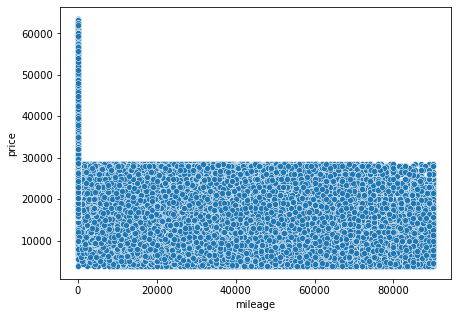

In [ ]:
# Visualizing the scatter plot of mileage and price
plt.figure(figsize=[7,5])
ax = sns.scatterplot(x = df['mileage'], y=df['price'])
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

we can see in the above scatter plot most of the mileage values are less than 300000, so need to remove other values

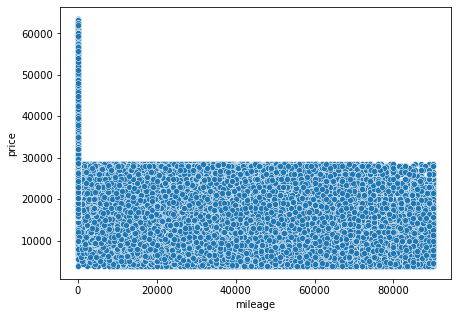

In [ ]:
# ploting the sctter plot of mileage and price
plt.figure(figsize=[7,5])
ax = sns.scatterplot(x = df['mileage'], y=df['price'])
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.get_yaxis().get_major_formatter().set_scientific(False)

# Feature Engineering

In [ ]:
# # transform crossover_car_and_van values into False=0 and True=1
df['crossover_car_and_van'] = df['crossover_car_and_van'].apply(lambda x: 0 if x == False else 1)
# # transform crossover_car_and_van values into False=0 and True=1
df['vehicle_condition'] = df['vehicle_condition'].apply(lambda x: 1 if x == 'NEW' else 0)

In [ ]:
# Converting year and mileage values into integer.
df['year_of_registration'] = df['year_of_registration'].astype('int64')
df['mileage'] = df['mileage'].astype('int64')

In [ ]:
# displaying datatypes of each variables
df.dtypes

mileage                   int64
standard_colour          object
standard_make            object
standard_model           object
vehicle_condition         int64
year_of_registration      int64
price                     int64
body_type                object
crossover_car_and_van     int64
fuel_type                object
dtype: object

In [ ]:
# Creating new feature age of vehicle
df['veh_age_years'] = df['year_of_registration'].max() - df['year_of_registration'] # Calculating age of vehicle by subtracting registration year from 2020

# Creating new feature average mileage per year of vehicle
df['avg_miles_per_year'] = df['mileage'] / df['veh_age_years'] # Calculating average mileage of vehicle by dividing mileage by age of vehicle.

In [ ]:
df['avg_miles_per_year'].describe()

count    2.863630e+05
mean              inf
std               NaN
min      0.000000e+00
25%      4.100000e+03
50%      6.160667e+03
75%      8.666667e+03
max               inf
Name: avg_miles_per_year, dtype: float64

In [ ]:
# check for infinity values of new created feature avg_mile
df[np.isinf(df['avg_miles_per_year'])]

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,veh_age_years,avg_miles_per_year
public_reference,,,,,,,,,,,,
201911043995897,5,BLACK,NISSAN,X-TRAIL,1,2021,27595,SUV,0,DIESEL,0,inf
202007161315831,10,WHITE,BMW,3 SERIES,1,2021,38905,ESTATE,0,DIESEL,0,inf
202009103570045,10,BLUE,VOLKSWAGEN,POLO,1,2021,16500,HATCHBACK,0,PETROL,0,inf
202009143697500,4,BLACK,VOLKSWAGEN,GOLF,1,2021,26292,HATCHBACK,0,PETROL,0,inf
202010054632179,1,WHITE,BMW,X3,1,2021,41980,SUV,0,DIESEL HYBRID,0,inf
...,...,...,...,...,...,...,...,...,...,...,...,...
202009294333848,10,RED,ALFA ROMEO,GIULIA,1,2021,38000,SALOON,0,PETROL,0,inf
202010024501227,10,SILVER,MITSUBISHI,SHOGUN SPORT,1,2021,31999,SUV,0,DIESEL,0,inf
202010104843364,5,RED,BMW,Z4,1,2021,47910,CONVERTIBLE,0,PETROL,0,inf


In [ ]:
# converting null and infinite values into to 0 of type 'int'
df['avg_miles_per_year'] = pd.to_numeric(df['avg_miles_per_year'], errors='coerce')
df['avg_miles_per_year'] = df['avg_miles_per_year'].replace(np.inf, int(float(0)))
df['avg_miles_per_year'] = df['avg_miles_per_year'].fillna(0).astype(int)
df['avg_miles_per_year'] = df['avg_miles_per_year'].astype('int64')

In [ ]:
# display unique values in crossover_car_and_van column
print(df['crossover_car_and_van'].unique())
print(f'Unique Values : {df["crossover_car_and_van"].nunique()}')

[0 1]
Unique Values : 2


In [ ]:
# display unique values in standard_colour column
print(df['standard_colour'].unique())
print(f'Unique Values : {df["standard_colour"].nunique()}')

['GREY' 'BROWN' 'RED' 'BLACK' 'WHITE' 'SILVER' 'BLUE' 'PURPLE' 'GREEN'
 'ORANGE' 'YELLOW' 'TURQUOISE' 'GOLD' 'BRONZE' 'BURGUNDY' 'MULTICOLOUR'
 'BEIGE' 'PINK' 'MAROON' 'MAGENTA' 'NAVY' 'INDIGO']
Unique Values : 22


In [ ]:
# display unique values in standard_make column
print(df['standard_make'].unique())
print(f'Unique Values : {df["standard_make"].nunique()}')

['SKODA' 'VAUXHALL' 'LAND ROVER' 'VOLKSWAGEN' 'PEUGEOT' 'SEAT' 'MINI'
 'BMW' 'MERCEDES-BENZ' 'NISSAN' 'CITROEN' 'TOYOTA' 'VOLVO' 'RENAULT'
 'AUDI' 'HONDA' 'JAGUAR' 'DS AUTOMOBILES' 'KIA' 'HYUNDAI' 'FIAT' 'SMART'
 'PORSCHE' 'MITSUBISHI' 'ABARTH' 'MAZDA' 'SUZUKI' 'MG' 'DACIA' 'SUBARU'
 'SSANGYONG' 'ALFA ROMEO' 'LEXUS' 'MASERATI' 'JEEP' 'BENTLEY' 'PANTHER'
 'DAIHATSU' 'CHEVROLET' 'ASTON MARTIN' 'SAAB' 'TVR' 'ROVER' 'INFINITI'
 'CHRYSLER' 'LOTUS' 'DAIMLER' 'DODGE' 'TRIUMPH' 'GREAT WALL' 'AUSTIN'
 'ROLLS-ROYCE' 'ISUZU' 'MORRIS' 'WESTFIELD' 'TIGER' 'HUMMER' 'CATERHAM'
 'CADILLAC' 'LONDON TAXIS INTERNATIONAL' 'MORGAN' 'INTERNATIONAL'
 'WOLSELEY' 'JENSEN' 'RELIANT' 'CORVETTE' 'LEYLAND' 'HOLDEN' 'AIXAM'
 'BEAUFORD' 'GMC' 'MEV' 'LANCIA' 'LINCOLN' 'CUPRA' 'GENTRY' 'SEBRING'
 'DAX' 'IVECO' 'OPEL' 'PONTIAC' 'MITSUOKA' 'ZENOS' 'ALPINE']
Unique Values : 84


In [ ]:
# display unique values in standard_model column
print(df['standard_model'].unique())
print(f'Unique Values : {df["standard_model"].nunique()}')

['YETI' 'MOKKA' 'RANGE ROVER SPORT' 'VIVA' 'PASSAT' '208' 'OCTAVIA' 'LEON'
 'HATCH' '2 SERIES GRAN TOURER' 'GOLF' 'C CLASS' 'CORSA' 'QASHQAI'
 'CITIGO' 'GRAND C4 SPACETOURER' 'YARIS' 'VERSO' 'V40' 'KOLEOS' 'V60'
 '5 SERIES GRAN TURISMO' 'A3' '108' 'JAZZ' 'XK8' 'POLO' 'CADDY LIFE'
 'INSIGNIA' 'A1' 'C1' 'Q3' 'S4' 'NOTE' 'DS 3' 'SOUL' 'V50' 'CONVERTIBLE'
 'IBIZA' 'IX20' 'FABIA' 'E CLASS' 'CLIO' 'T-ROC' 'TIGUAN' '500C' 'A CLASS'
 'MOKKA X' 'MICRA' '107' 'AURIS' '5 SERIES' 'SCIROCCO' 'TARRACO' 'GOLF SV'
 'C3 AIRCROSS' 'C-HR' 'KAMIQ' 'DS 3 CABRIO' 'FORFOUR' 'I800' '500' 'X1'
 'CROSSLAND X' 'ZOE' 'A4' 'RANGE ROVER EVOQUE' 'BOXSTER' 'AYGO' 'RAV4'
 'OUTLANDER' '595C' 'SANTA FE' 'XF' 'DISCOVERY SPORT' 'CX-5' 'T-CROSS'
 'XC60' '4 SERIES' 'I30' 'GLA CLASS' 'CR-V' 'MAZDA3' 'A5' 'PRIUS+' '3008'
 'KADJAR' 'SWIFT' 'X-TRAIL' 'C4 CACTUS' 'SORENTO' 'CEED' 'CAPTUR' 'IX35'
 'SPORTAGE' 'JUKE' 'A6 ALLROAD' 'COUNTRYMAN' '3 SERIES' 'MG ZS' 'RIO'
 '500L' 'A4 AVANT' 'SANDERO STEPWAY' 'I20' 'WRX STI' 'CADDY' '308

In [ ]:
# display unique values in body_type
print(df['body_type'].unique())
print(f'Unique Values : {df["body_type"].nunique()}')

['SUV' 'HATCHBACK' 'SALOON' 'ESTATE' 'MPV' 'CONVERTIBLE' 'COUPE'
 'COMBI VAN' 'PICKUP' 'MINIBUS' 'LIMOUSINE' 'PANEL VAN' 'CAMPER'
 'WINDOW VAN' 'CHASSIS CAB']
Unique Values : 15


In [ ]:
# display unique values in fuel_type column
print(df['fuel_type'].unique())
print(f'Unique Values : {df["fuel_type"].nunique()}')

['PETROL' 'DIESEL' 'PETROL HYBRID' 'ELECTRIC' 'PETROL PLUG-IN HYBRID'
 'DIESEL HYBRID' 'BI FUEL' 'DIESEL PLUG-IN HYBRID']
Unique Values : 8


In [ ]:
df.head()

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,year_of_registration,price,body_type,crossover_car_and_van,fuel_type,veh_age_years,avg_miles_per_year
public_reference,,,,,,,,,,,,
202007020778474,7800,GREY,SKODA,YETI,0,2017,14000,SUV,0,PETROL,4,1950
202007080986776,45000,BROWN,VAUXHALL,MOKKA,0,2016,7995,HATCHBACK,0,DIESEL,5,9000
202007161321269,64000,GREY,LAND ROVER,RANGE ROVER SPORT,0,2015,26995,SUV,0,DIESEL,6,10666
202007080998445,24075,RED,VAUXHALL,VIVA,0,2017,5861,HATCHBACK,0,PETROL,4,6018
202007151278313,77000,GREY,VOLKSWAGEN,PASSAT,0,2010,4499,SALOON,0,DIESEL,11,7000


In [ ]:
df=df.drop(['year_of_registration'], axis =1)

In [ ]:
# displaying the feature of dataframe
df.columns

Index(['mileage', 'standard_colour', 'standard_make', 'standard_model',
       'vehicle_condition', 'price', 'body_type', 'crossover_car_and_van',
       'fuel_type', 'veh_age_years', 'avg_miles_per_year'],
      dtype='object')

In [ ]:
# displaying the datatypes of dataframe
df.dtypes

mileage                   int64
standard_colour          object
standard_make            object
standard_model           object
vehicle_condition         int64
price                     int64
body_type                object
crossover_car_and_van     int64
fuel_type                object
veh_age_years             int64
avg_miles_per_year        int64
dtype: object

In [ ]:
#Let's create a obeject corr_matrix as the result of passing the df to the .corr() method.
import phik
corr_matrix = df.phik_matrix()

interval columns not set, guessing: ['mileage', 'vehicle_condition', 'price', 'crossover_car_and_van', 'veh_age_years', 'avg_miles_per_year']


<AxesSubplot:>

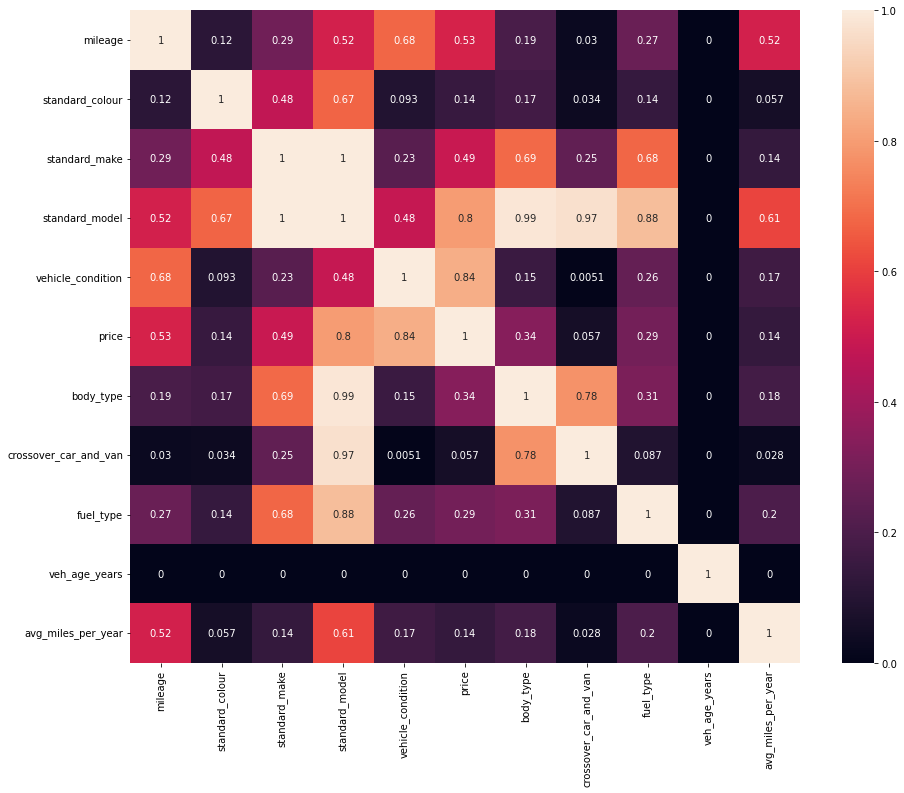

In [ ]:
plt.figure(figsize=(15,12))
sns.heatmap(corr_matrix, annot=True)

In [ ]:
# Slicing the dataset to display the correlated columns with "price" with greater values on the top.
corr_matrix["price"].sort_values(ascending=False)

price                    1.000000
vehicle_condition        0.843728
standard_model           0.798499
mileage                  0.530653
standard_make            0.494803
body_type                0.338413
fuel_type                0.293638
standard_colour          0.144984
avg_miles_per_year       0.137588
crossover_car_and_van    0.057130
veh_age_years            0.000000
Name: price, dtype: float64

In [ ]:
# We will be working with a sample of the dataset
seed = 1337
dfs = df.sample(frac=0.2,random_state=seed)
dfs.shape

(59016, 11)

In [ ]:
dfs

,mileage,standard_colour,standard_make,standard_model,vehicle_condition,price,body_type,crossover_car_and_van,fuel_type,veh_age_years,avg_miles_per_year
public_reference,,,,,,,,,,,
202006180257182,71379,SILVER,VOLKSWAGEN,JETTA,0,6566,SALOON,0,DIESEL,8,8922
202009234086547,8336,BLACK,VOLVO,XC40,0,27495,SUV,0,PETROL,2,4168
202010165059268,0,SILVER,AUDI,Q5,1,50316,SUV,0,PETROL PLUG-IN HYBRID,0,0
202009304387722,20586,SILVER,MINI,HATCH,0,13295,HATCHBACK,0,PETROL,4,5146
202010084761000,16755,BROWN,VAUXHALL,ASTRA,0,7875,HATCHBACK,0,PETROL,7,2393
...,...,...,...,...,...,...,...,...,...,...,...
202009013157974,49355,WHITE,INFINITI,Q70,0,12199,SALOON,0,PETROL HYBRID,6,8225
202010134938901,39000,WHITE,SUZUKI,SPLASH,0,3899,HATCHBACK,0,PETROL,8,4875
202010305596097,10704,WHITE,SEAT,LEON,0,23495,HATCHBACK,0,PETROL,2,5352


In [ ]:
# indicate target colums
target=dfs["price"]
# indicate columns that will serve as features
features=dfs.drop(columns=["price", "crossover_car_and_van"])

In [ ]:
# passing features and labels to train_test_split to create X_train, X_test, y_train, y_test ate the rate 80%/20%
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [ ]:
#Target encoding standard_make and standard_model columns of the training and test datasets
encoder = TargetEncoder(cols=['standard_make','standard_model']).fit(X_train, y_train)
X_train = encoder.transform(X_train)
X_test = encoder.transform(X_test)

In [ ]:
#Preprocessing and transforming the numerical and categorical features of the training and test set using pipeline
num_feat = ['mileage','veh_age_years','avg_miles_per_year']
num_transformer = Pipeline(steps=[
    ('poly',PolynomialFeatures(interaction_only=True, include_bias=False)),
    ('scaler', StandardScaler())
]).set_output(transform='pandas')


cat_feat = ['standard_colour','body_type','fuel_type']
cat_transformer = Pipeline(steps=[
    ('ohe', OneHotEncoder(handle_unknown='infrequent_if_exist', sparse_output=False, drop='if_binary'))
]).set_output(transform='pandas')

preprocessor = ColumnTransformer(
    transformers=
    [
        ('num_feat', num_transformer, num_feat),
        ('cat_feat', cat_transformer, cat_feat)
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")

# Apply the preprocessor on the test set
preprocessor.fit(X_train, y_train)
X_train = preprocessor.transform(X_train)
X_test = preprocessor.transform(X_test)

In [ ]:
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('num_feat',
                                 Pipeline(steps=[('poly',
                                                  PolynomialFeatures(include_bias=False,
                                                                     interaction_only=True)),
                                                 ('scaler', StandardScaler())]),
                                 ['mileage', 'veh_age_years',
                                  'avg_miles_per_year']),
                                ('cat_feat',
                                 Pipeline(steps=[('ohe',
                                                  OneHotEncoder(drop='if_binary',
                                                                handle_unknown='infrequent_if_exist',
                                                                sparse_output=False))]),
                                 ['standard_colour', 'body_type',
                                  'fuel_type'])],
                  verbose_feature_names_out=False)

# Feature Selection and Dimensionality Reduction

### Automated Feature Selection

In [ ]:
#Applying automated feature selection using Kbest
selector = SelectKBest(f_regression, k=10)
selector.fit(X_train, y_train)

X_train_kbest = selector.transform(X_train)
X_test_kbest = selector.transform(X_test)

In [ ]:
X_train_kbest

array([[ 1.53611757e-01, -1.29553932e-01,  6.54191945e-01, ...,
         2.20741313e+04,  2.54943761e+04,  0.00000000e+00],
       [-9.92538166e-01, -4.79028291e-01, -5.78935590e-01, ...,
         8.55497979e+03,  8.81383623e+03,  0.00000000e+00],
       [-4.65711210e-01, -3.04291111e-01,  1.51082009e-01, ...,
         1.21942157e+04,  1.59929796e+04,  0.00000000e+00],
       ...,
       [-1.10862662e+00, -4.79028291e-01, -9.25268339e-01, ...,
         1.20307613e+04,  1.34571910e+04,  0.00000000e+00],
       [-1.31086583e+00, -6.53765470e-01, -1.52544292e+00, ...,
         9.35496747e+03,  1.33274366e+04,  0.00000000e+00],
       [-1.31150461e+00, -6.53765470e-01, -1.52925436e+00, ...,
         1.39222068e+04,  2.52345492e+04,  0.00000000e+00]])

### Dimensionality Reduction

In [ ]:
#Dimensionality reduction using PCA
pca_full = PCA()
pca_full.fit(X_train)

PCA()

In [ ]:
pca_full.explained_variance_ratio_

array([8.53531750e-01, 1.46468038e-01, 1.08648589e-07, 3.98764221e-08,
       9.77475840e-09, 8.47443270e-09, 6.42808314e-09, 5.56488790e-09,
       4.98005026e-09, 4.24504912e-09, 3.55169125e-09, 3.36256736e-09,
       3.05634883e-09, 2.90030023e-09, 1.94158966e-09, 1.52581146e-09,
       1.38154376e-09, 1.15147687e-09, 1.00185533e-09, 9.60612703e-10,
       6.77335190e-10, 4.55137161e-10, 4.13186862e-10, 2.80292091e-10,
       2.78352791e-10, 1.87262425e-10, 1.44620854e-10, 1.27500313e-10,
       1.16620202e-10, 9.18395966e-11, 8.38378283e-11, 5.36254639e-11,
       4.78321565e-11, 4.68217883e-11, 2.45462121e-11, 2.03099699e-11,
       1.77222853e-11, 1.27205550e-11, 1.26492540e-11, 6.86074499e-12,
       5.45201729e-12, 4.13745269e-12, 3.82902978e-12, 3.15273318e-12,
       2.86900143e-12, 2.39673364e-12, 1.81725472e-12, 6.14796992e-13,
       2.20784383e-16, 3.70961279e-33, 3.70961279e-33, 3.70961279e-33])

Number of PCA components: 2


Text(0, 0.5, 'Cummulative Explained Variance')

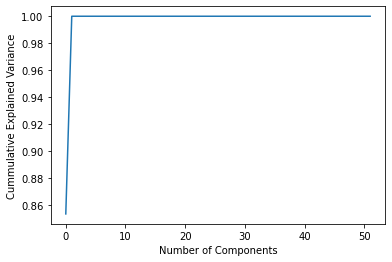

In [ ]:
pca_evr=np.cumsum(pca_full.explained_variance_ratio_)
num=np.argmax(pca_evr >=0.95)+1
print("Number of PCA components:", num)
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cummulative Explained Variance")

In [ ]:
pca = PCA(n_components= 2)
pca.fit(X_train, y_train)
X_train_pca= pca.transform(X_train)
X_test_pca= pca.transform(X_test)

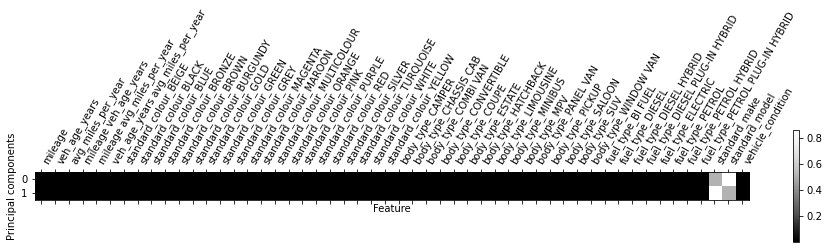

In [ ]:
plt.matshow(np.abs(pca.components_), cmap='Greys_r')
plt.colorbar()
plt.xticks(range(len(X_train.columns)),
           X_train.columns,rotation=60, ha='left')
plt.xlabel("Feature")
plt.ylabel("Principal components");

# Model Building

In [ ]:
#Define the models
regr_model = LinearRegression()
regr_model1 = RandomForestRegressor()
regr_model2 = HistGradientBoostingRegressor()




In [ ]:
#Fit the Linear Regression on the train and test set
regr_model.fit(X_train_kbest, y_train)
lr_pred = regr_model.predict(X_test_kbest)
regr_model.score(X_test_kbest, y_test)

0.7809916539568177

In [ ]:
#Print the root mean square error
rmse(y_test, lr_pred)

3773.6671296354093

In [ ]:
#Fit RandomForest Regressor to the train and test set
regr_model1.fit(X_train_kbest, y_train)
rf_pred = regr_model1.predict(X_test_kbest)
regr_model1.score(X_test_kbest, y_test)

0.9039073659444957

In [ ]:
#Print the root mean square error
rmse(y_test, rf_pred)

2499.644832595521

In [ ]:
#Fit the HistGradientBossting Regressor on the train and test set
regr_model2.fit(X_train_kbest, y_train)
Hist_pred = regr_model2.predict(X_test_kbest)
regr_model2.score(X_test_kbest, y_test)

0.9016709627700209

In [ ]:
#Print the root mean square error
rmse(y_test, Hist_pred)

2528.565160034411

### GridSearch

In [ ]:
# Define the hyperparameter grid
rf = RandomForestRegressor()

param_grid = {
    "max_depth": [2, 4, 10, 20],
    "n_estimators": [20, 50, 100],
    "max_features": [10, 20, 50]
}

# Create the GridSearchCV object
rf_grid = GridSearchCV(rf, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="neg_mean_squared_error")

# Fit the GridSearchCV object to the training data
rf_grid.fit(X_train_kbest, y_train)

# Print the best hyperparameters and score
print(f"Best parameters: {rf_grid.best_params_}")
print(f"Best score: {np.sqrt(-rf_grid.best_score_)}")

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best parameters: {'max_depth': 20, 'max_features': 20, 'n_estimators': 100}
Best score: 2453.6888259294524


In [ ]:
# Train the model on the entire training set using the best hyperparameters
rf_best = rf_grid.best_estimator_
rf_best.fit(X_train_kbest, y_train)

# Evaluate the model on the test set
rf_y_pred = rf_best.predict(X_test_kbest)

# Evaluate the performance of the model on the test set using mean squared error and R-squared
mse = mean_squared_error(y_test, rf_y_pred)
r2 = r2_score(y_test, rf_y_pred)
print("Mean squared error:", mse)
print("R-squared:", r2)
print("Root Mean squared error:", np.sqrt(mse))

Mean squared error: 6034364.146161808
R-squared: 0.9071963619064785
Root Mean squared error: 2456.494279692466


In [ ]:
#Cross validation for RandomForest Regressor
rf_scores = cross_val_score(rf_best, X_train_kbest, y_train, cv=10, scoring='neg_root_mean_squared_error')
rf_scores.mean()*-1, rf_scores.std()

(2432.3538927446093, 40.603699857361605)

In [ ]:
# Define the hyperparameter grid
hist = HistGradientBoostingRegressor()

param_grid = {
    "learning_rate": [0.01, 0.1],
    "max_depth": [2, 4, 10, 20],
    "min_samples_leaf": [1, 5, 10],
    "max_iter": [100, 200, 300, 600]
}

# Create the GridSearchCV object
hgr_grid = GridSearchCV(hist, param_grid, cv=5, n_jobs=-1, verbose=1, scoring="neg_mean_squared_error")

# Fit the GridSearchCV object to the training data
hgr_grid.fit(X_train_kbest, y_train)

# Print the best hyperparameters and score
print(f"Best parameters: {hgr_grid.best_params_}")
print(f"Best score: {np.sqrt(-hgr_grid.best_score_)}")

Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best parameters: {'learning_rate': 0.1, 'max_depth': 10, 'max_iter': 600, 'min_samples_leaf': 1}
Best score: 2339.65842682919


In [ ]:
# Train the model on the entire training set using the best hyperparameters
hgr_best = hgr_grid.best_estimator_
hgr_best.fit(X_train_kbest, y_train)

# Evaluate the model on the test set
hgr_y_pred = hgr_best.predict(X_test_kbest)

# Evaluate the performance of the model on the test set using mean squared error and R-squared
mse = mean_squared_error(y_test, hgr_y_pred)
r2 = r2_score(y_test, hgr_y_pred)
print("Mean squared error:", mse)
print("R-squared:", r2)
print("Root Mean squared error:", np.sqrt(mse))

Mean squared error: 5444487.274338312
R-squared: 0.9162681909188634
Root Mean squared error: 2333.342511149684


In [ ]:
#Cross validation for HistGradientBossting Regressor
hgr_scores = cross_val_score(hgr_best, X_train_kbest, y_train, cv=10, scoring='neg_root_mean_squared_error')
hgr_scores.mean()*-1, hgr_scores.std()

(2326.8669985559873, 53.086607146387216)

In [ ]:
#Applying the best parameters per model and stacking the models up in an ensemble (VotingRegressor)
rf = RandomForestRegressor(n_estimators=100, max_depth=20, max_features=20)
hgbr = HistGradientBoostingRegressor(learning_rate=0.1, max_depth=20, max_iter=600, min_samples_leaf=5)

estimators = [('rf', rf), ('hgbr', hgbr)]

# Create the VotingRegressor
ensemble = VotingRegressor(estimators)

# Fit the VotingRegressor
ensemble.fit(X_train_kbest, y_train)

# Make predictions and evaluate the model
ensemble_pred = ensemble.predict(X_test_kbest)
ensemble.score(X_test_kbest, y_test)

0.9175931044587716

In [ ]:
rmse(y_test, ensemble_pred)

2314.8083113958487

### Overall Cross Validation

In [ ]:
# Define the list of models in the ensemble
models = [rf, hgbr, ensemble]

# Iterate over the models and print the cross-validation scores
for i, model in enumerate(models):
    # Fit the model on the training data
    model.fit(X_train_kbest, y_train)

    # Calculate the cross-validation scores
    scores = cross_val_score(model, X_train_kbest, y_train, cv=10, scoring='neg_root_mean_squared_error')
    mean_score = -1 * scores.mean()
    std_score = scores.std()

    # Print the scores
    if i == len(models) - 1:
        print("Ensemble RMSE: {:.2f} (+/- {:.2f})".format(mean_score, std_score))
    else:
        print("{} RMSE: {:.2f} (+/- {:.2f})".format(type(model).__name__, mean_score, std_score))


RandomForestRegressor RMSE: 2432.56 (+/- 40.91)
HistGradientBoostingRegressor RMSE: 2317.02 (+/- 37.06)
Ensemble RMSE: 2311.19 (+/- 44.94)


In [ ]:
xt = X_test_kbest[:20]
pred1 = rf.predict(xt)
pred2 = hgbr.predict(xt)
pred3 = ensemble.predict(xt)

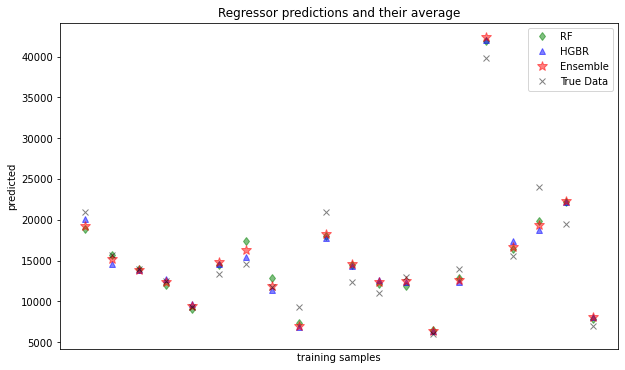

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(pred1, "gd", alpha=0.5, label="RF")
plt.plot(pred2, "b^", alpha=0.5, label="HGBR")
plt.plot(pred3, "r*", alpha=0.5, ms=10, label="Ensemble")
plt.plot(y_test.head(20).to_numpy(), "kx", alpha=0.5, label="True Data")

plt.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
plt.ylabel("predicted")
plt.xlabel("training samples")
plt.legend(loc="best")
plt.title("Regressor predictions and their average")

plt.show()

# True vs Predicted Values

In [ ]:
y_pred = ensemble.predict(X_test_kbest)
mse = mean_squared_error(y_test, y_pred)
mae=mean_absolute_error(y_test,y_pred)
r2 = r2_score(y_test, y_pred)

print("Test MSE:", mse)
print("Test RMSE:", np.sqrt(mse))
print("Test R-squared:", r2)

Test MSE: 5363012.363287531
Test RMSE: 2315.8178605597486
Test R-squared: 0.9175212091285231


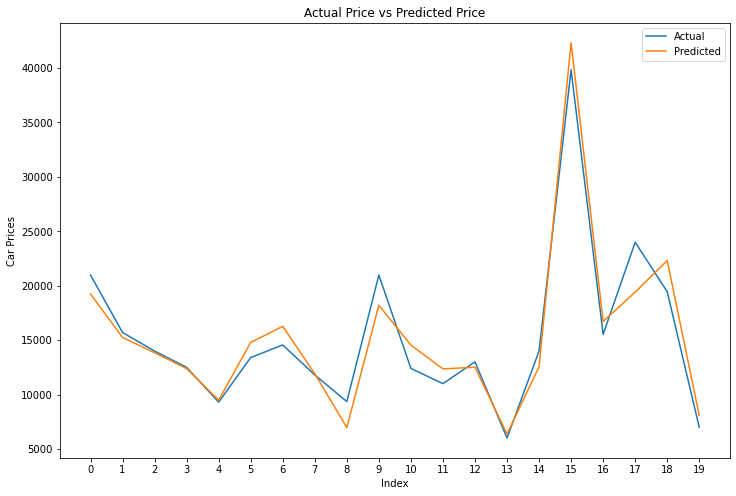

In [ ]:
# Plot the Actual vs Predicted Evaluation
ax = range(len(y_test[:20]))
plt.figure(figsize=(12,8))
plt.plot(ax, y_test[:20], label="Actual")
plt.plot(ax, y_pred[:20], label="Predicted")
plt.title("Actual Price vs Predicted Price")
plt.xlabel('Index')
plt.ylabel('Car Prices')
plt.xticks(np.arange(20))
plt.legend()
plt.show()

### Global and Local Explanations with SHAP

In [ ]:
explainer = shap.TreeExplainer(hgr_best)

In [ ]:
X_eval = pd.DataFrame(X_test_kbest, columns=selector.get_feature_names_out())
shap_values = explainer(X_eval)


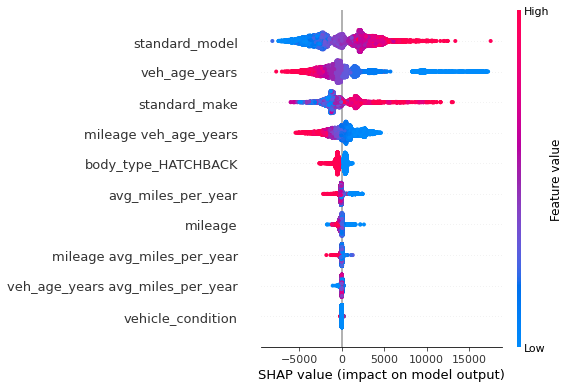

In [ ]:
shap.summary_plot(
    shap_values)


### Partial Dependency Plots (PDP)

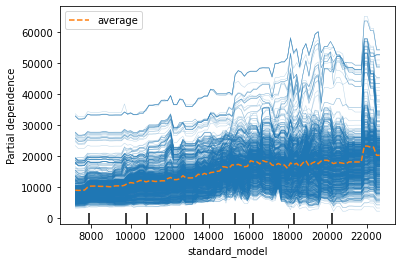

In [ ]:

# Create PDP plot for the 'temp' feature using PartialDependenceDisplay
PartialDependenceDisplay.from_estimator(
    hgr_best,
    X_eval,
    features=['standard_model'],
    kind='both'
)


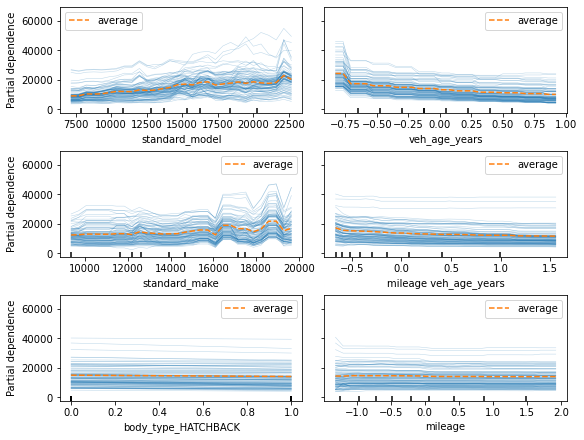

In [ ]:
top_features=["standard_model", "veh_age_years", "standard_make", "mileage veh_age_years", "body_type_HATCHBACK", "mileage"]
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgr_best, X_eval, features=top_features,
    kind='both',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

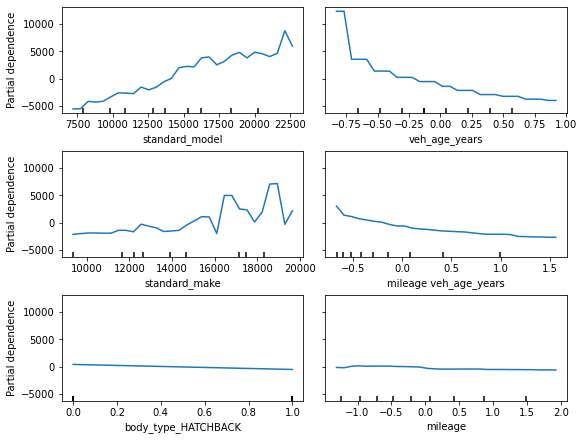

In [ ]:
top_features=["standard_model", "veh_age_years", "standard_make", "mileage veh_age_years", "body_type_HATCHBACK", "mileage"]
fig, ax = plt.subplots(figsize=(8,6), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgr_best, X_eval, features=top_features,
    kind='average',
    subsample=100, grid_resolution=30, n_jobs=2, random_state=0,
    ax=ax, n_cols=2
);

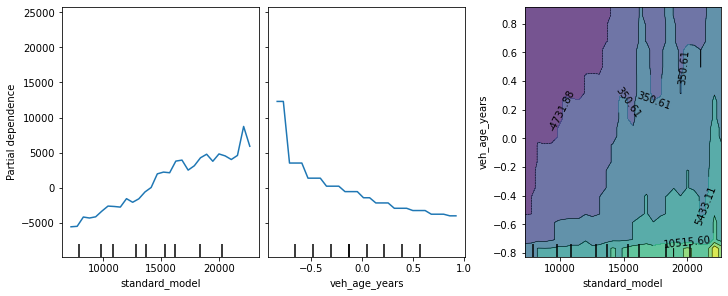

In [ ]:
fig, ax = plt.subplots(figsize=(10,4), constrained_layout=True)
PartialDependenceDisplay.from_estimator(
    hgr_best, X_eval,
    features=["standard_model", "veh_age_years", ("standard_model", "veh_age_years")],
    kind='average',
    ax=ax, n_cols=3,
    subsample=50, grid_resolution=30, n_jobs=2, random_state=0,
);

###